In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
from scipy.optimize import minimize
import statsmodels.api as sm

In [56]:
np.random.seed(0)
n = 100
x = np.linspace(-2, 2, n)
y = (x > 0).astype(int) 

X = sm.add_constant(x)  # add intercept

# fit logit
model = sm.Logit(y, X)
try:
    result = model.fit(disp=0)
    print(result.summary())
except Exception as e:
    print("Fitting failed (as expected due to separation):", e)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                   1.000
Time:                        16:28:11   Log-Likelihood:            -1.8764e-08
converged:                      False   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 5.308e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.882e-09   7300.284   2.58e-13      1.000   -1.43e+04    1.43e+04
x1           914.9820   3.61e+05      0.003      0.998   -7.07e+05    7.09e+05

Complete Separation: The results show that there is

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationW

In [57]:

# Wald CI (normal approx)
conf_int_wald = result.conf_int()
print("Wald CI:\n", conf_int_wald)

Wald CI:
 [[ -14308.29378347   14308.29378347]
 [-707345.56031207  709175.52425117]]


In [13]:
!pip install ci-rvm

In [61]:
# Fix beta_1 and optimize beta_0
def log_likelihood(beta1_val):
    def neg_loglik(beta0):
        linpred = beta0 + beta1_val * x
        p = expit(linpred)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    res = minimize(neg_loglik, x0=0)
    return -res.fun  # return log-likelihood
# Evalute profile likelihood over beta_1 grid
beta1_vals = np.linspace(0, 100, 3000)
ll_vals = np.array([log_likelihood(b1) for b1 in beta1_vals])
ll_max = ll_vals.max()
cutoff = ll_max - 0.5 * 3.84  # 95% CI threshold (chi2_1 = 3.84), from LRS
# Find lower bound
valid = beta1_vals[ll_vals >= cutoff]
beta1_lower = valid[0] if len(valid) > 0 else None
print(f"Profile likelihood 95% lower bound for β₁: {beta1_lower:.2f}")

Profile likelihood 95% lower bound for β₁: 18.47


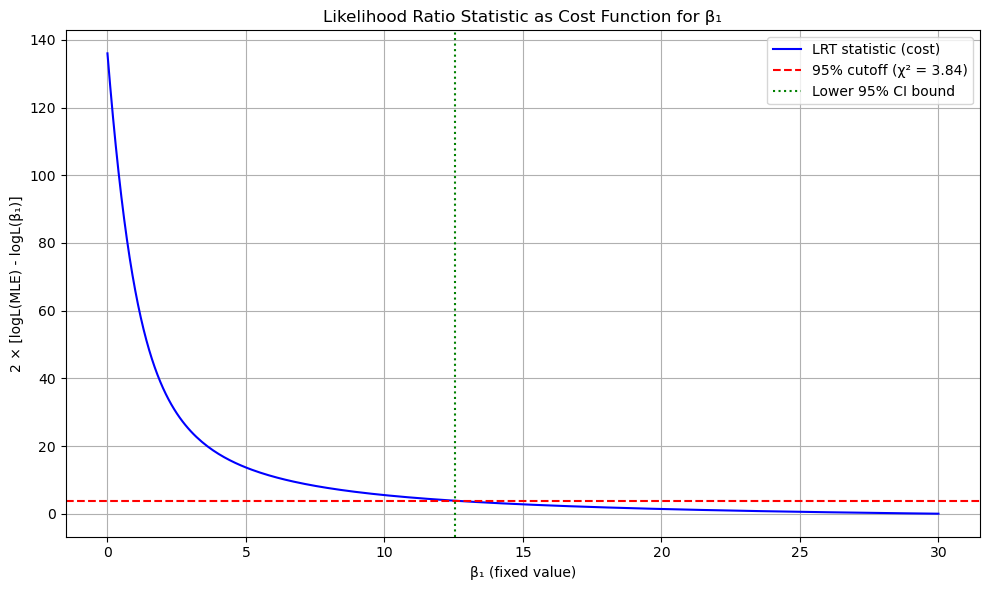

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.optimize import minimize

# Simulate data with perfect separation
np.random.seed(0)
n = 100
x = np.linspace(-2, 2, n)
y = (x > 0).astype(int)

# Step 1: Define profile log-likelihood by maximizing over beta_0
def profile_loglik(beta1_val):
    def neg_loglik(beta0):
        eta = beta0 + beta1_val * x
        p = expit(eta)
        p = np.clip(p, 1e-8, 1 - 1e-8)  # avoid log(0)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    res = minimize(neg_loglik, x0=0.0, method="BFGS")
    return -res.fun if res.success else -np.inf

# Step 2: Evaluate profile log-likelihood over beta_1 grid with 300 points (discrete cases because of failure in find_CI)
beta1_vals = np.linspace(0, 30, 300)
ll_vals = np.array([profile_loglik(b1) for b1 in beta1_vals])
ll_max = np.max(ll_vals)

# Step 3: Compute likelihood ratio statistic as a "cost function"
lrt_vals = 2 * (ll_max - ll_vals)
threshold = 3.84  # chi^2_1 95% quantile

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.plot(beta1_vals, lrt_vals, label="LRT statistic (cost)", color="blue")
plt.axhline(y=threshold, color="red", linestyle="--", label="95% cutoff (χ² = 3.84)")
plt.axvline(x=beta1_vals[lrt_vals <= threshold][0], color="green", linestyle=":", label="Lower 95% CI bound")
plt.title("Likelihood Ratio Statistic as Cost Function for β₁")
plt.xlabel("β₁ (fixed value)")
plt.ylabel("2 × [logL(MLE) - logL(β₁)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


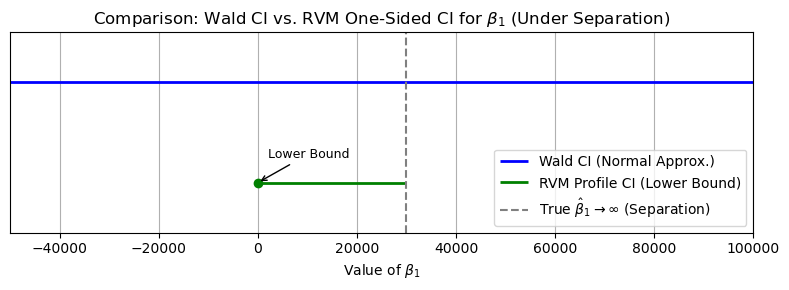

In [2]:
# Re-import necessary libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt

# CI values from earlier
wald_ci_beta1 = [-707345.56, 709175.52]   # Wald CI for beta_1
rvm_lower_bound = 12.54  # Example value based on profile likelihood or RVM result
true_beta1 = np.inf    # Since under separation, the true MLE → ∞

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 3))

# Plot the Wald CI
ax.hlines(y=1, xmin=wald_ci_beta1[0], xmax=wald_ci_beta1[1], color='blue', linewidth=2, label='Wald CI (Normal Approx.)')
ax.plot(wald_ci_beta1, [1, 1], 'o', color='blue')

# Plot the RVM one-sided lower bound
ax.hlines(y=0.6, xmin=rvm_lower_bound, xmax=30000, color='green', linewidth=2, label='RVM Profile CI (Lower Bound)')
ax.plot([rvm_lower_bound], [0.6], 'o', color='green')
ax.annotate("Lower Bound", xy=(rvm_lower_bound, 0.6), xytext=(rvm_lower_bound + 2000, 0.7),
            arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=9)

# True beta (diverging)
ax.axvline(x=30000, color='gray', linestyle='--', label='True $\\hat{\\beta}_1 \\to \\infty$ (Separation)')

# Axis formatting
ax.set_xlim(-50000, 100000)
ax.set_ylim(0.4, 1.2)
ax.set_xlabel('Value of $\\beta_1$')
ax.set_yticks([])
ax.set_title('Comparison: Wald CI vs. RVM One-Sided CI for $\\beta_1$ (Under Separation)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [41]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
from ci_rvm import find_CI

# Simulate perfectly separated data
x = np.linspace(-2, 2, 5000)
y = (x > 0).astype(int)

# Define profile log-likelihood for fixed beta1
def profile_loglik(beta1_val):
    def neg_loglik(beta0):
        eta = beta0 + beta1_val * x
        p = expit(eta)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    res = minimize(neg_loglik, x0=0.0, method="BFGS")
    return -res.fun if res.success else -np.inf

# Wrapper needed by ci_rvm that accepts vector input
def rvm_loglik(params):
    params = np.atleast_1d(params)
    return profile_loglik(params[0])

# Initial guess must be an array, not scalar
x0 = np.array([10.2])

import numdifftools as nd

# Compute 1D gradient array manually
g = nd.Gradient(rvm_loglik)
grad0 = g(np.array([1.0]))
if grad0.shape == ():  # 0D array
    grad0 = np.array([grad0.item()])  # Make it 1D explicitly

# Same for Hessian if needed
hess0 = nd.Hessian(rvm_loglik)(np.array([1.0]))
if hess0.shape == ():  # Hessian may also be 0D if scalar
    hess0 = np.array([[hess0.item()]])

# Now pass manually into find_CI
ci_result = find_CI(
    x0=np.array([1.0]),
    fun=rvm_loglik,
    indices=[0],
    directions=[[-1]],
    alpha=0.05,
    jac=lambda x: grad0,
    hess=lambda x: hess0,
    return_full_results=True
)

print("Lower 95% bound for β₁:", ci_result[0])
## doesn't work


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/ci_rvm/ci_rvm.py:1147: RuntimeWarning: divide by zero encountered in scalar divide
  fImprovement = np.log2(np.abs((f-target)/(fActual-target)))
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=ax

Lower 95% bound for β₁: [ message: Result on discontinuity
  success: False
   status: 1
      fun: -1728.419489344008
        x: [ 1.000e+00]
      nit: 2
      jac: []
     nfev: 67
     njev: 13
     nhev: 1
  x_track: []
  f_track: []                     ]


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt

In [ ]:
import inspect
from ci_rvm import find_CI

print(inspect.getsource(find_CI))


@inherit_doc(find_CI_bound)
def find_CI(x0, fun, jac=None, hess=None, indices=None, directions=None, alpha=0.95, 
            parallel=False, return_full_results=False, return_success=False,
            **kwargs):
    """Returns the profile likelihood confidence interval(s) for one or 
    multiple parameters.
    
    Parameters
    ----------
    indices : int[]
        Indices of the parameters of interest. If not given, all paramters
        will be considered.
    directions : float[][]
        Search directions. If not given, both end points of the confidence
        intervals will be determined. If given as a scalar, only lower
        end points will be returned if ``directions<=0`` and upper end points 
        otherwise. If given as an array, the confidence interval end points 
        specified in row ``i`` will be returned for parameter ``i``. Entries ``<=0``
        indicate that lower end points are desired, whereas positive entries 
        will result in upper end point

In [28]:
pip show ci-rvm

Name: ci-rvm
Version: 0.10.1b3
Summary: An algorithm to find profile likelihood confidence intervals
Home-page: https://github.com/vemomoto/vemomoto
Author: Samuel M. Fischer
Author-email: 
License: LGPLv3
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: numdifftools, numpy, scipy, vemomoto-core-tools
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [30]:
return_full_results=True

In [34]:
import numdifftools as nd

g = nd.Gradient(rvm_loglik)
print("Gradient:", g(np.array([1.0])))
print("Type:", type(g(np.array([1.0]))))
print("Shape:", np.shape(g(np.array([1.0]))))


Gradient: 21.90060504214483
Type: <class 'numpy.ndarray'>
Shape: ()


In [37]:
print("Gradient shape:", grad0.shape)
print("Hessian shape:", hess0.shape)


Gradient shape: (1,)
Hessian shape: (1, 1)


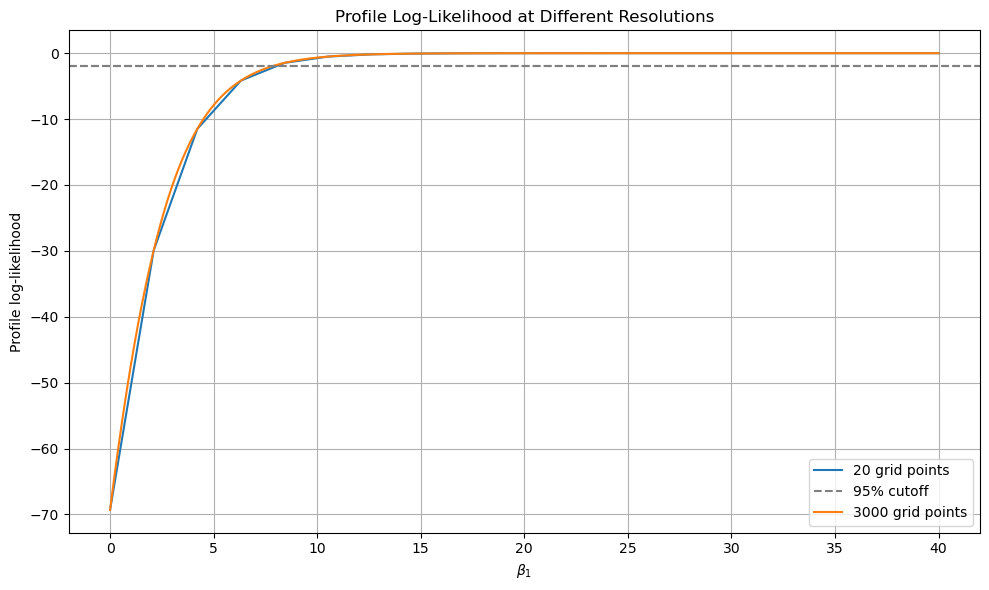

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit

# Simulated data with separation
np.random.seed(0)
n = 100
x = np.concatenate([np.zeros(n // 2), np.ones(n // 2)])
y = np.concatenate([np.zeros(n // 2), np.ones(n // 2)])

# Profile log-likelihood function: for fixed beta1, optimize over beta0
def log_likelihood(beta1_val):
    def neg_loglik(beta0):
        linpred = beta0 + beta1_val * x
        p = expit(linpred)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    res = minimize(neg_loglik, x0=0)
    return -res.fun

# Different resolutions
resolutions = [20, 3000]
beta1_bounds = (0, 40)
cutoff_factor = 0.5 * 3.84  # 95% CI threshold (chi^2_1)

# Plotting
plt.figure(figsize=(10, 6))
for res in resolutions:
    beta1_vals = np.linspace(beta1_bounds[0], beta1_bounds[1], res)
    ll_vals = np.array([log_likelihood(b1) for b1 in beta1_vals])
    ll_max = ll_vals.max()
    plt.plot(beta1_vals, ll_vals, label=f'{res} grid points')
    plt.axhline(ll_max - cutoff_factor, linestyle='--', color='gray', label='95% cutoff' if res == resolutions[0] else None)

plt.title("Profile Log-Likelihood at Different Resolutions")
plt.xlabel(r"$\beta_1$")
plt.ylabel("Profile log-likelihood")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

